In [1]:
import gensim
from loveisland.common.functions import import_all
from loveisland.common.constants import ORIGINAL_ISLANDERS, PALETTE
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
def str_to_list(string):
    return (
        string.replace("[", "")
        .replace("]", "")
        .replace("'", "")
        .replace(" ", "")
        .split(",")
    )


def ngrams(df, col="processed_text"):
    ngram = gensim.models.Phrases(df[col])
    df[col] = df[col].apply(lambda x: ngram[x])
    return df


def get_tokens(df, col="processed_text"):
    return [item for sublist in df[col].to_list() for item in sublist]


def get_ngrams(df, col="processed_text"):
    df["inc_ngram"] = df[col].apply(lambda x: "yes" if "_" in x else "no")
    return [i for i in get_tokens(df) if "_" in i and "status" not in i]


def get_df(df, date, col="processed_text"):
    n = df.url.nunique()
    df = get_counts(get_tokens(df, col))
    df["n_tweets"] = n
    df["date"] = date
    df["percent"] = df["count"] / sum(df["count"])
    return df

def get_counts(tokens):
    counts = Counter(tokens)
    counts = pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
    counts.index.name = "token"
    return (
        counts.reset_index()
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

def count_df(df, group):
    return df.groupby(group)["url"].count().reset_index(name="count")

In [3]:
df = import_all()
df = df[df["date"] < "2019-06-03"]

In [4]:
df["processed_text"] = df["processed_text"].apply(lambda x: str_to_list(x))
df["islanders"] = df["islanders"].apply(lambda x: str_to_list(x))
df = ngrams(df)
df = ngrams(df)

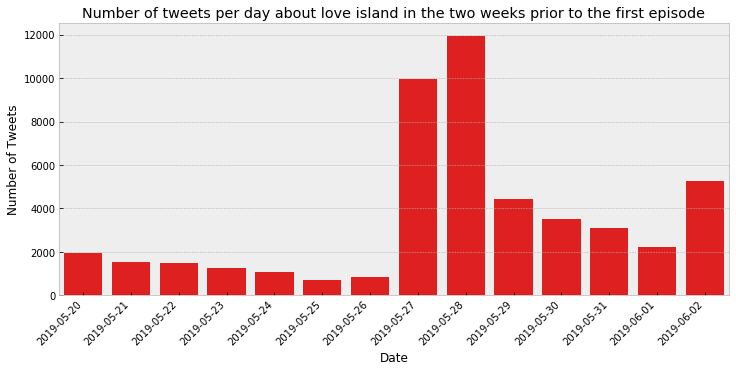

In [5]:
to_plot = count_df(df, "date").sort_values("date", ascending=True)
to_plot["date"] = to_plot["date"].astype(str)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.title("Number of tweets per day about love island in the two weeks prior to the first episode");

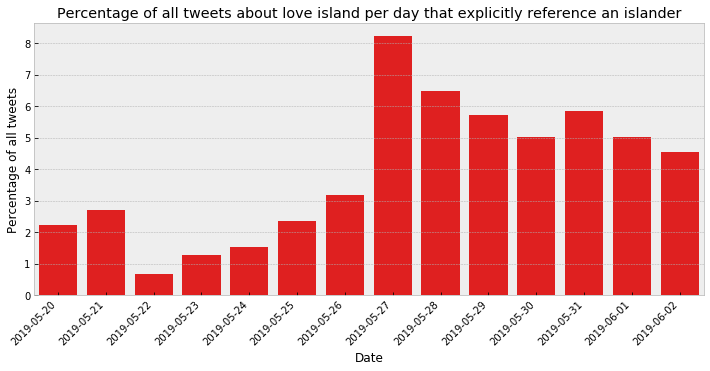

In [6]:
def inc_islander(df, col="islanders"):
    df[col] = df[col].apply(lambda x: [i for i in x if i in ORIGINAL_ISLANDERS])
    df["inc_islander"] = np.where(df[col].str.len() < 1, "No", "Yes")
    df = count_df(df, ["date", "inc_islander"]) 
    df["perc"] = df.groupby(["date"])["count"].apply(lambda x: x*100 / sum(x))
    return df[df["inc_islander"] == "Yes"]

to_plot = inc_islander(df)
to_plot["date"] = to_plot["date"].astype(str)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, ax=ax1, color="Red")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Percentage of all tweets")
plt.title("Percentage of all tweets about love island per day that explicitly reference an islander");

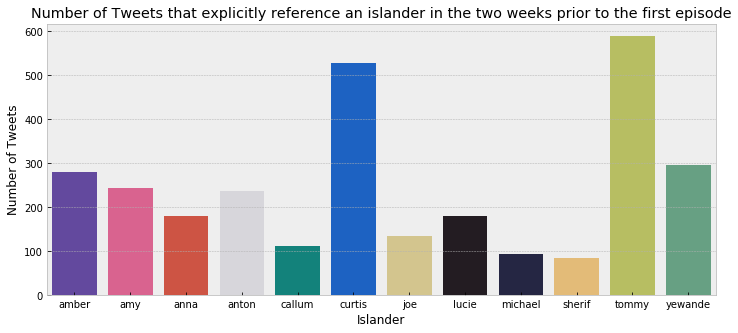

In [7]:
counts = df.count()
counts.index.name = "islander"
counts = counts.reset_index(name="count")
counts = counts[counts["islander"].isin(ORIGINAL_ISLANDERS)]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("islander", "count", "islander", data=counts, ax=ax1, palette=PALETTE, dodge=False)

plt.legend().remove()
plt.xlabel("Islander")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets that explicitly reference an islander in the two weeks prior to the first episode");

In [8]:
n_grams = get_ngrams(df)
counts = get_counts(n_grams)
counts.head(15)

,token,count
0,not_wait,1149
1,plus_size,557
2,mental_health,557
3,start_tomorrow,492
4,tommy_fury,414
5,new_cast,414
6,caroline_flack,409
7,will_not,392
8,body_diversity,340
9,thesun_tvandshowbiz,334


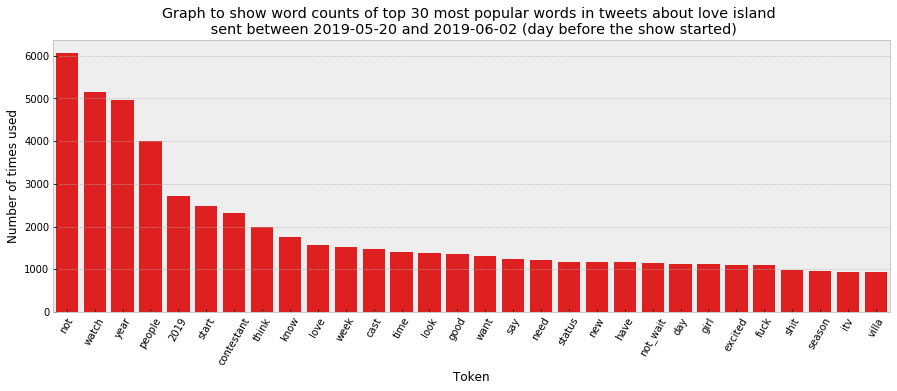

In [9]:
counts = get_df(df, "all")

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

sns.barplot("token", "count", data=counts.head(30), color="Red", ax=ax1)

plt.xticks(rotation=60)
plt.xlabel("Token")
plt.ylabel("Number of times used")
plt.title("Graph to show word counts of top 30 most popular words in tweets about love island \n \
sent between 2019-05-20 and 2019-06-02 (day before the show started)");

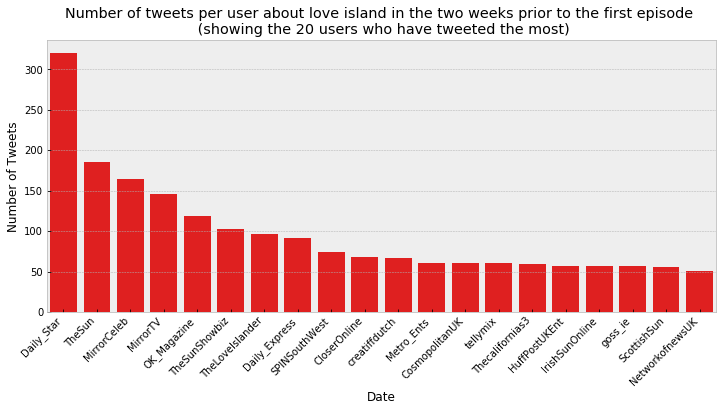

In [10]:
to_plot = count_df(df, "user")
to_plot = to_plot.sort_values("count", ascending=False).head(20)

to_plot["user"] = to_plot["user"].astype(str)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("user", "count", data=to_plot, color="Red", ax=ax1)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.title("Number of tweets per user about love island in the two weeks prior to the first episode \n \
(showing the 20 users who have tweeted the most)");

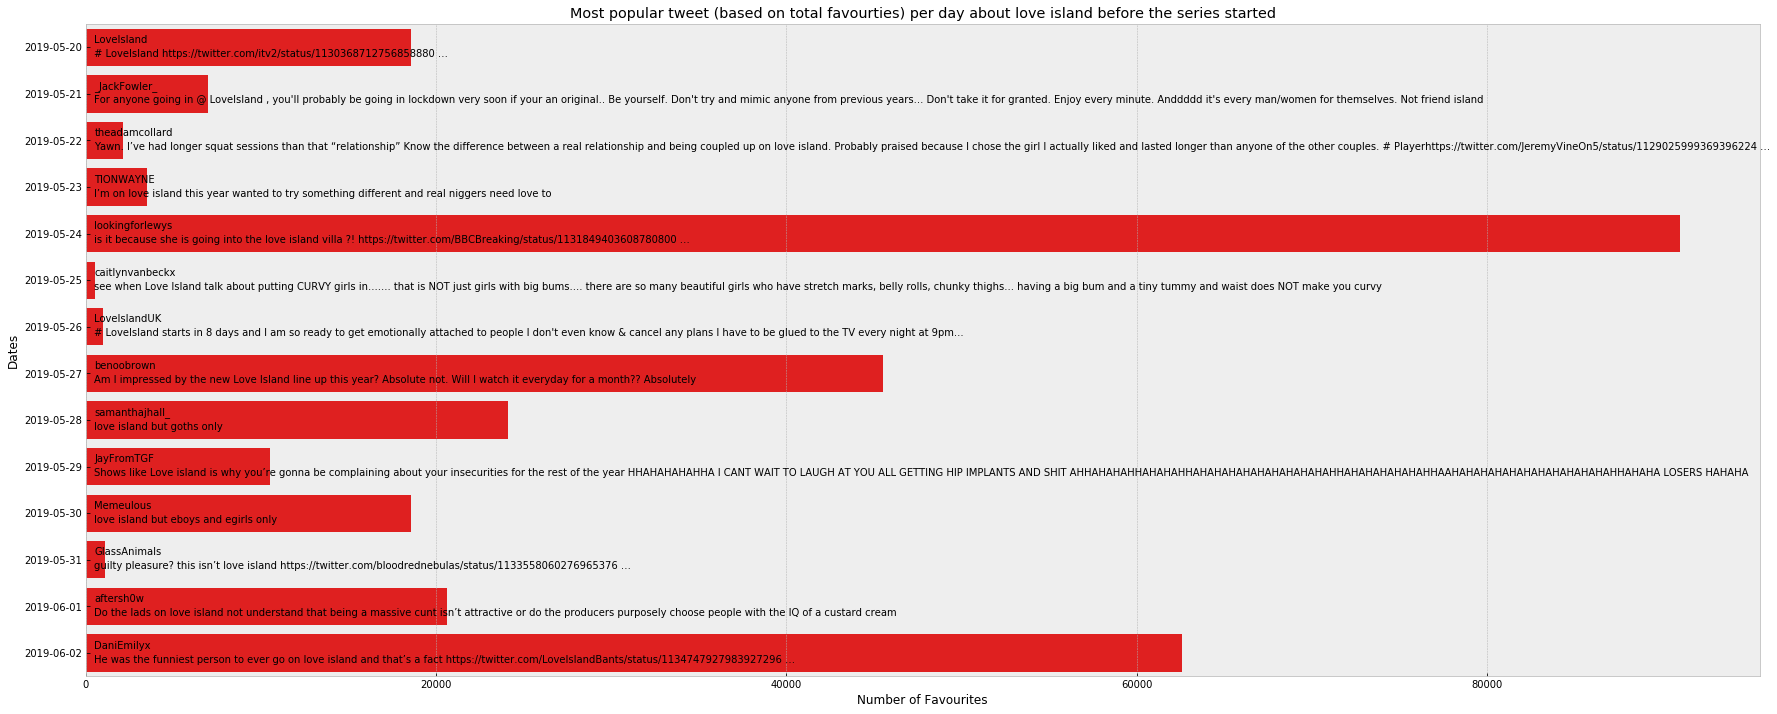

In [11]:
df["text"] = df["text"].astype(str)
most_pop = df[~df["text"].str.contains("pic")]\
             .sort_values("favs", ascending=False)\
             .groupby("date").head(1)\
             .sort_values("date", ascending=True)\
             .reset_index(drop=True)
most_pop["date"] = most_pop["date"].astype(str)

fig = plt.figure(figsize=(30, 12))
ax1 = fig.add_subplot(111)

sns.barplot("favs", "date", data=most_pop, color="Red", ax=ax1)
for i, row in most_pop.iterrows():
    ax1.annotate(row["text"], xy=(0,0), xytext=(500, i+0.2))
    ax1.annotate(row["user"], xy=(0,0), xytext=(500, i-0.1))
    
plt.ylabel("Dates")
plt.xlabel("Number of Favourites")
plt.title("Most popular tweet (based on total favourties) per day about love island before the series started");